<a href="https://colab.research.google.com/github/asuyou/colabs/blob/main/LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series with LSTM

Link: [original](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

LSTM allows us to take into account previous output as part of input

We can store state with cells and update it with gates

## Steps

1. *Decide what data is no longer relevant.* Handled by forget gate with $\sigma$ activation
2. *Update cell data with input gate.* New NN layer with $\tanh$ activation
3. Update old state value
4. Generate model based of previous output and input

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Number of samples. E.g. 100 sine waves
N = 100
L = 1000
T = 20

x = np.empty((N,L), np.float32)
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

In [ ]:
# sns.lineplot(
#     x=x[0],
#     y=y[0]
# )

In [ ]:
class LSTM(nn.Module):
  def __init__(self, hidden_layers=64):
    super(LSTM, self).__init__()
    self.hidden_layers = hidden_layers

    self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
    self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
    self.lstm3 = nn.LSTMCell(self.hidden_layers, 1)

    self.linear = nn.Linear(self.hidden_layers, 1)
  
  def forward(self, y, future_preds=0):
    outputs, n_samples = [], y.size(0)

    # h is a tensor of with inital state of all elements
    # c is a tensor with state for the cells
    h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
    c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
    h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
    
    for time_step in y.split(1, dim=1):
      # print(time_step)
      h_t, c_t = self.lstm1(time_step, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      # output = self.lstm3(h_t, (h_t2, c_t2))
      # print(output.shape)
      outputs.append(output)

    for i in range(future_preds):
      h_t, c_t = self.lstm1(output, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      # output = self.lstm3(h_t, (h_t2, c_t2))
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    return outputs


## Forward Method

Cell takes 3 parameters as `input, (h_0, c_0)`

- `input`: Tensor of size `(batch, input_size)`
- `h_0`: Inital hidden state for each element in the batch
- `c_0`: Inital state for each element in the batch

A cell will output `(h_1, c_1)`

This is similar to above but `h_1` is the next hidden state and `c_1` is next cell state

Batch size is 100 as define at the start with the number of sine waves.

Next step is passing in correct tensor. $m$

```py
y.split(a, dim=b)
```

If `a` is not passed, we get chunks of size 1. Instead we want rows so we set `a` to 1 and `b` to 1

```py
a = torch.from_numpy(y[3:, :-1])
b = a.split(1, dim=1)
b[0].shape

>>> torch.Size([97, 1])
```



Next stage leads to predicting future time steps.

Must concatinate array to create scalar tensors

In [ ]:
train_input = torch.from_numpy(y[3:, :-1])
train_target = torch.from_numpy(y[3:, 1:])

test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)

In [ ]:
model = LSTM()

criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

In [ ]:
import matplotlib.pyplot as plt

def training_loop(n_epochs,
                  model,
                  optimiser,
                  loss_fn,
                  train_input,
                  train_target,
                  test_input,
                  test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss

        optimiser.step(closure)

        with torch.no_grad():
            future = 2000
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

Step: 0, Loss: 0.023832473903894424
Step: 1, Loss: 0.01586342602968216
Step: 2, Loss: 0.008281211368739605
Step: 3, Loss: 0.0013167792931199074
Step: 4, Loss: 0.0011310052359476686
Step: 5, Loss: 0.0010659617837518454
Step: 6, Loss: 0.000699653581250459
Step: 7, Loss: 0.0004327146743889898
Step: 8, Loss: 0.000283285160548985
Step: 9, Loss: 0.00015104844351299107
Step: 10, Loss: 0.00013589646550826728
Step: 11, Loss: 0.00012181870260974392
Step: 12, Loss: 9.22461404115893e-05
Step: 13, Loss: 7.737212581560016e-05
Step: 14, Loss: 6.377326644724235e-05
Step: 15, Loss: 5.037008668296039e-05
Step: 16, Loss: 3.0763760150875896e-05
Step: 17, Loss: 1.3331842637853697e-05
Step: 18, Loss: 1.074312149285106e-05
Step: 19, Loss: 9.691884770290926e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 20, Loss: 7.802902473486029e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 21, Loss: 6.754167316103121e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 22, Loss: 5.929181952524232e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 23, Loss: 5.687941211363068e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 24, Loss: 5.527916528080823e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 25, Loss: 5.241937742539449e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 26, Loss: 5.088792931928765e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 27, Loss: 4.983654889656464e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 28, Loss: 4.909275503450772e-06


<ipython-input-8-8a3cc233e772>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


Step: 29, Loss: 4.811813141714083e-06


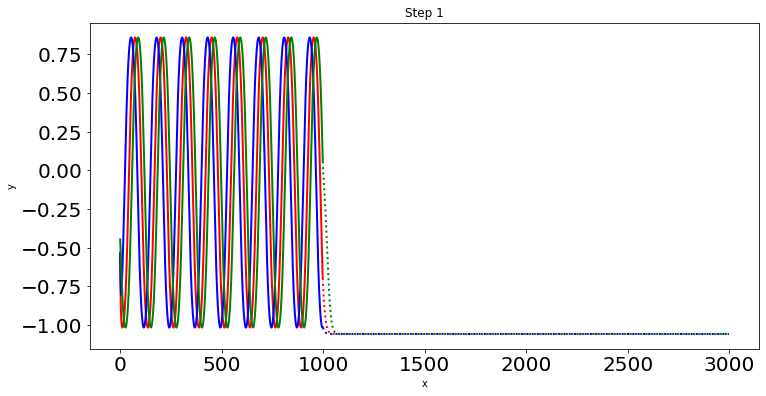

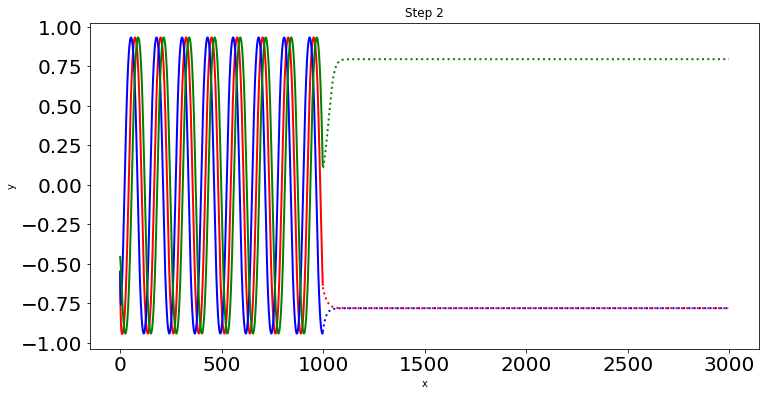

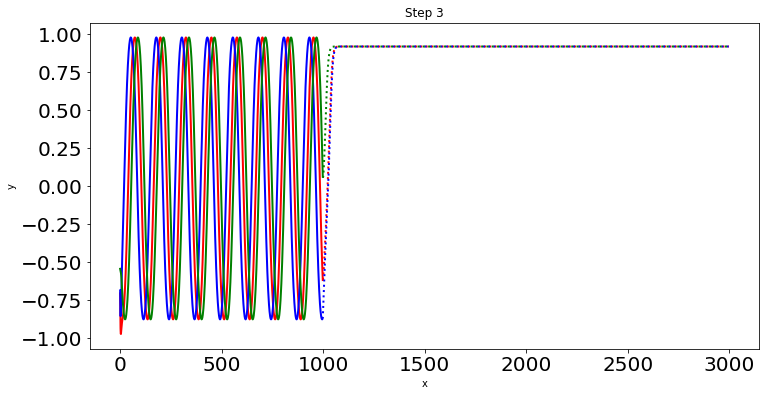

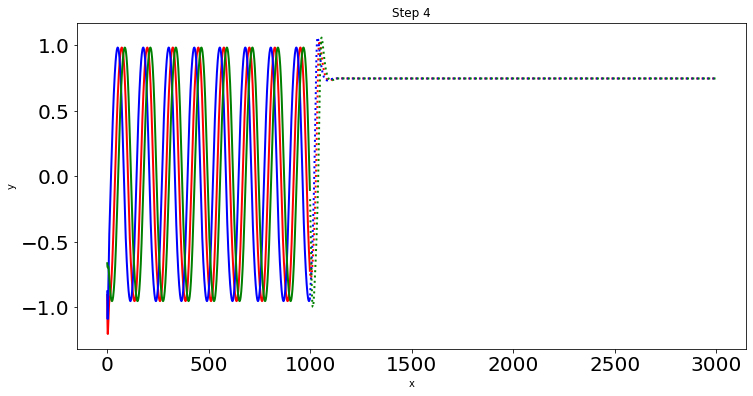

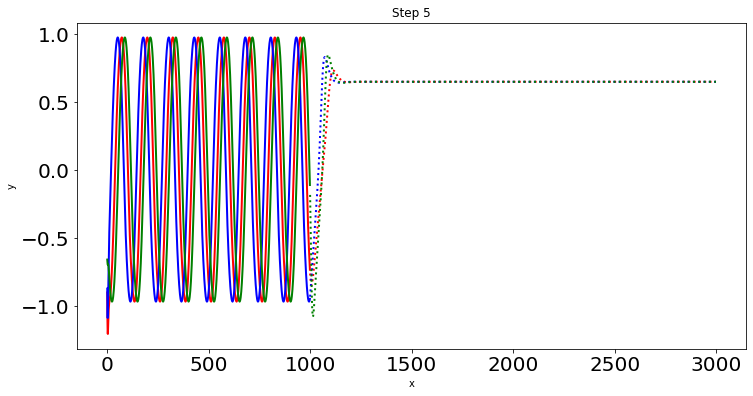

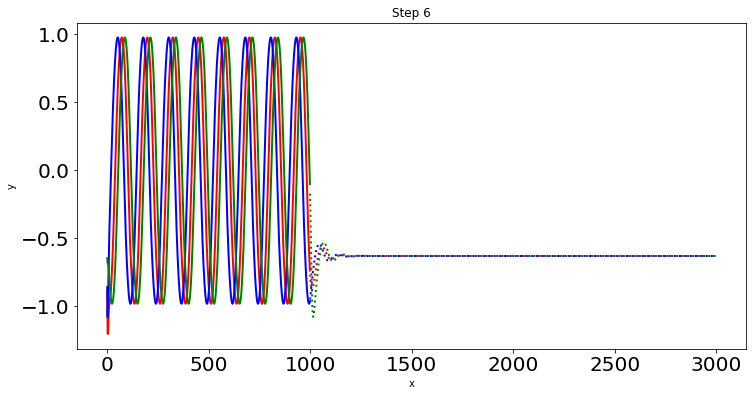

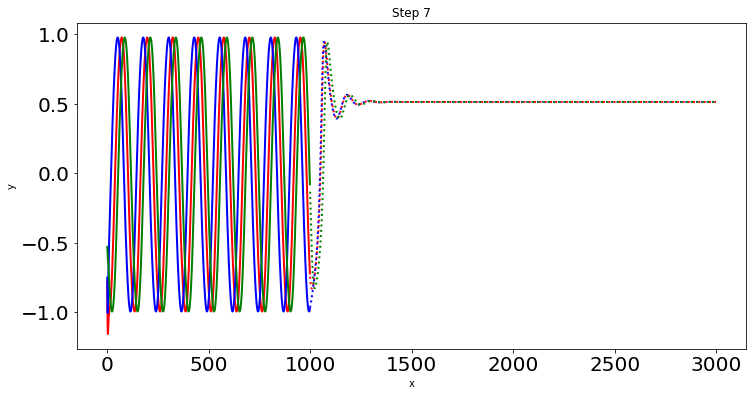

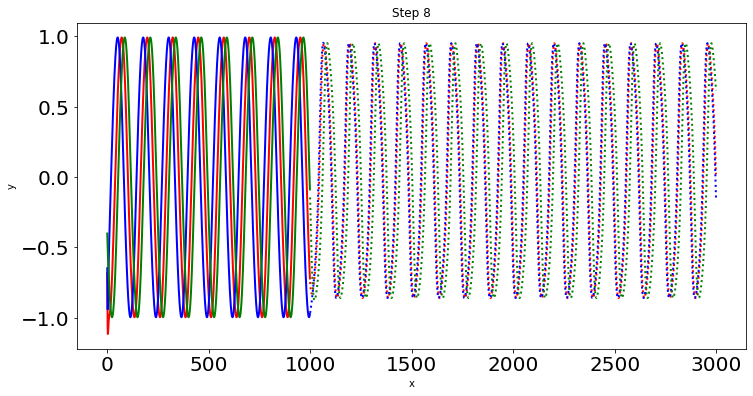

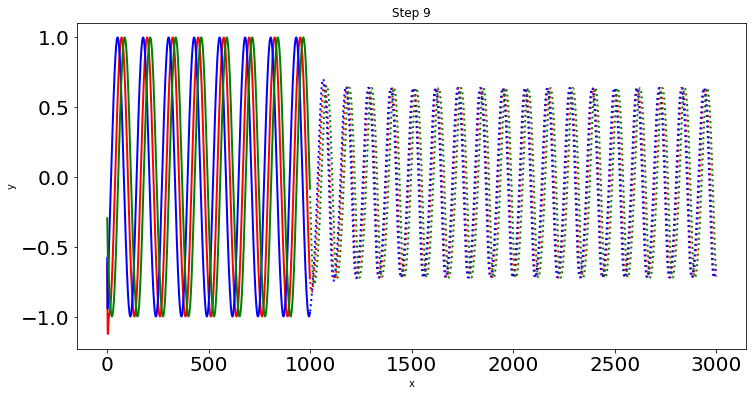

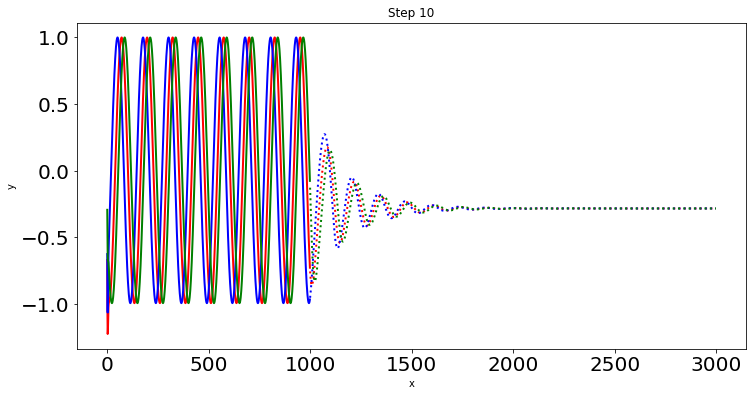

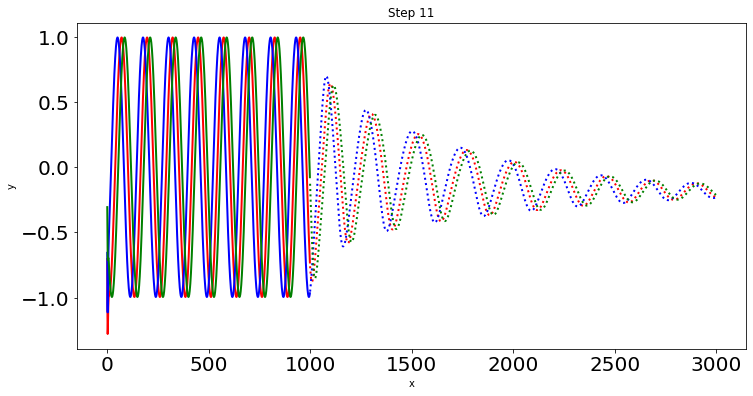

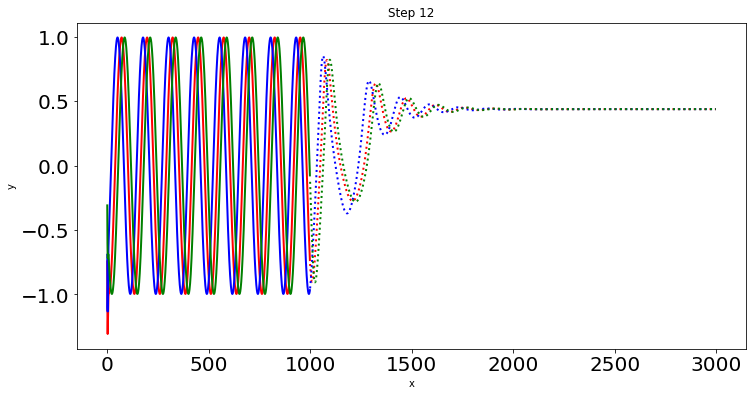

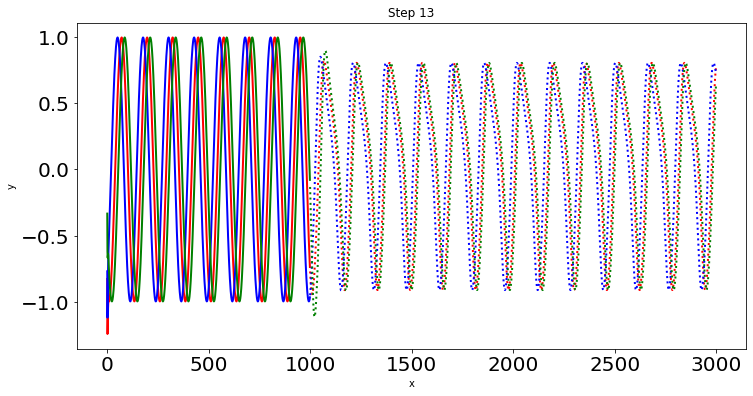

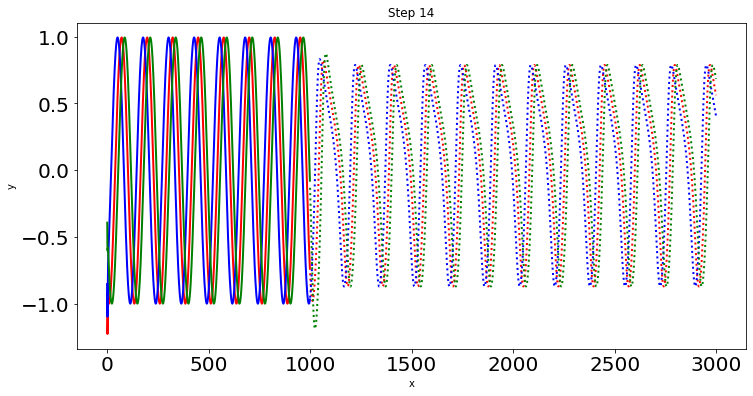

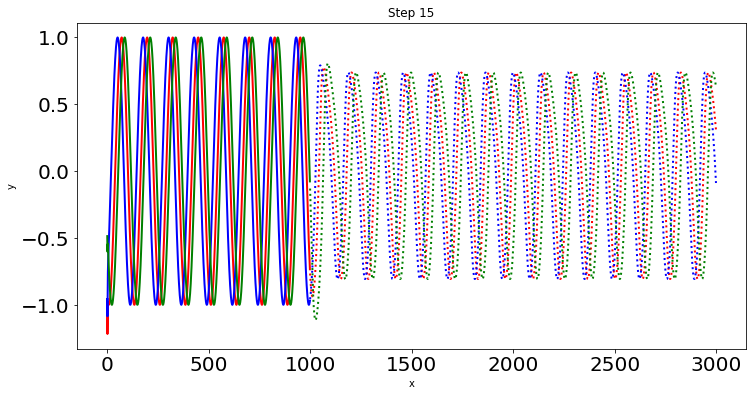

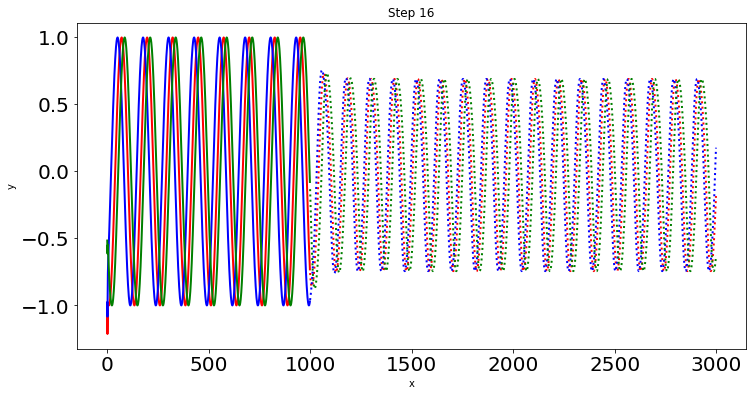

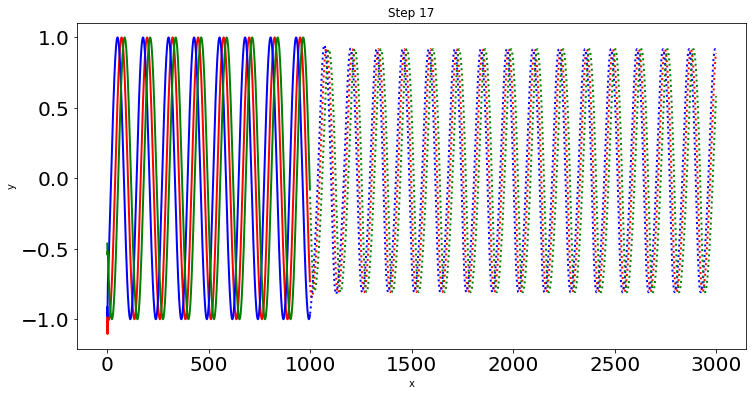

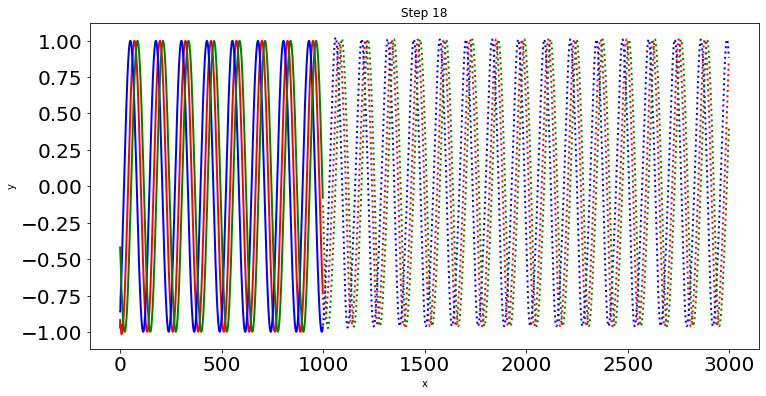

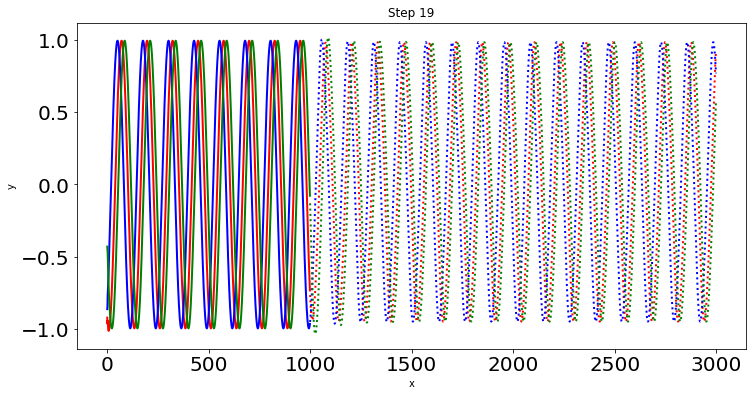

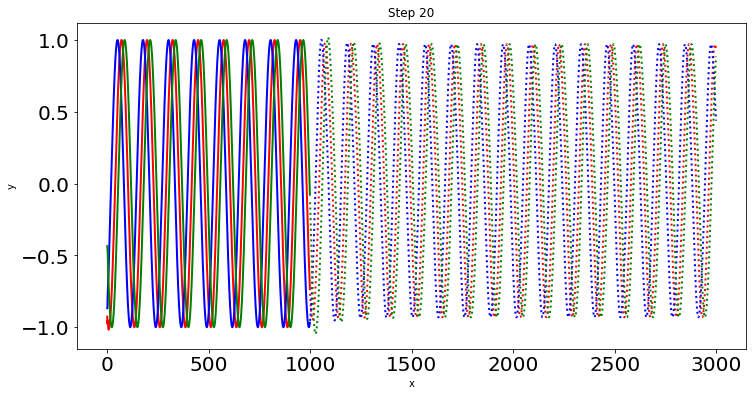

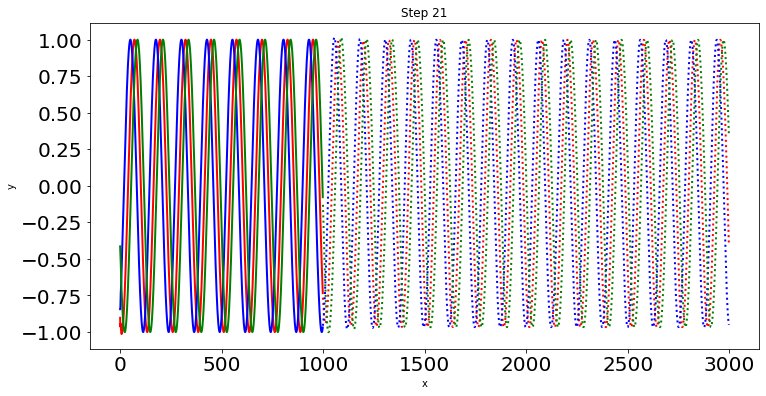

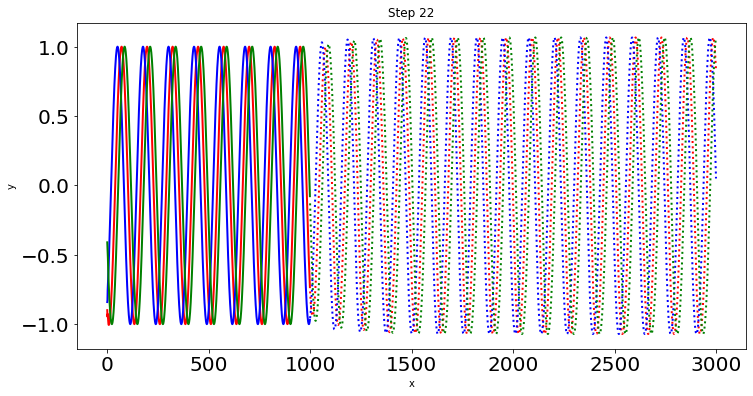

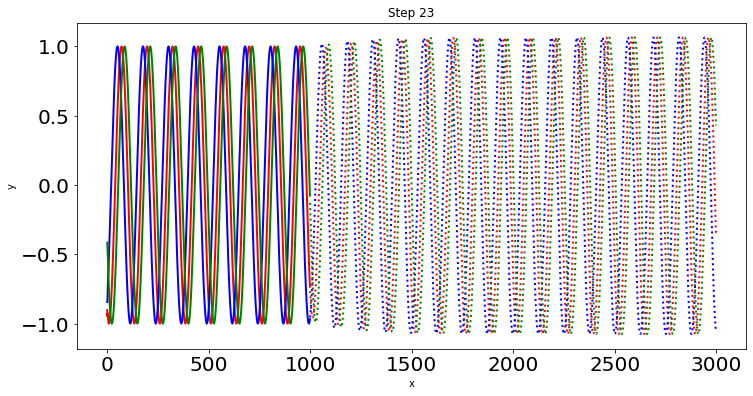

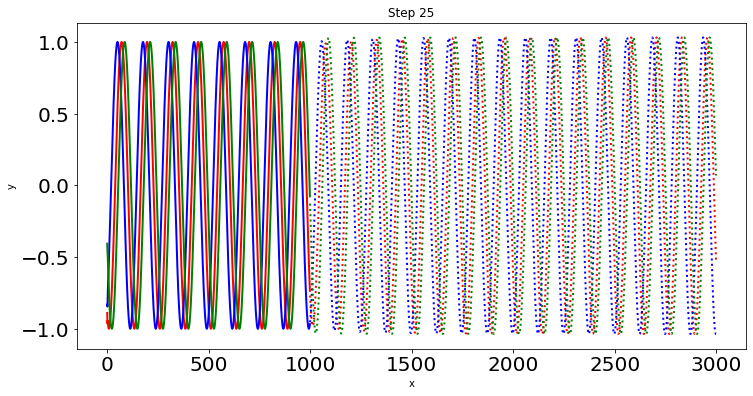

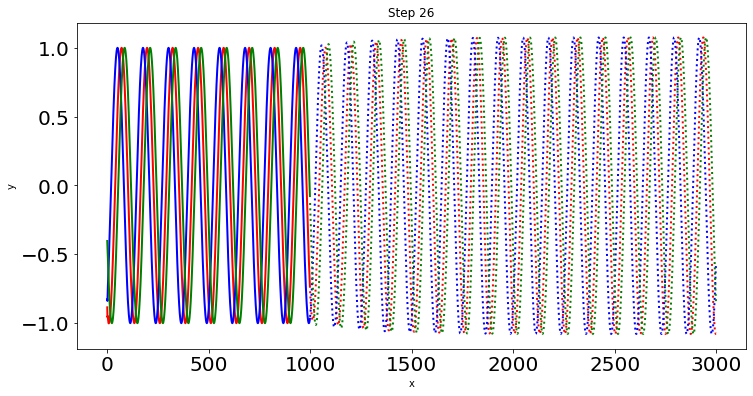

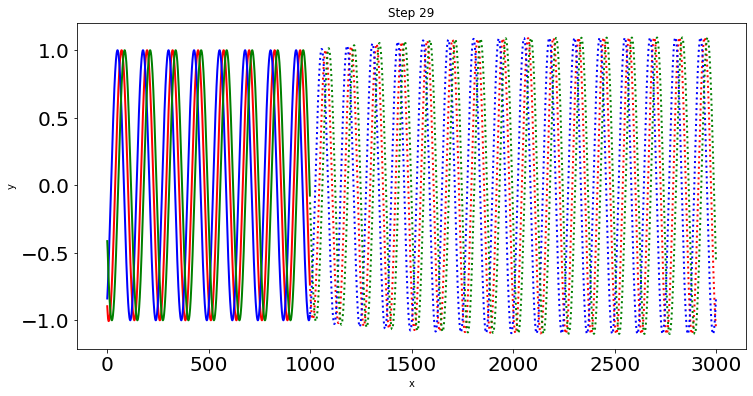

In [ ]:
training_loop(n_epochs=30,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)
